In [20]:
import matplotlib.pyplot as plt
import pandas as pd 
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

To explore anomaly dection, we'll use data on ebola cases (a little more serious than spam complaints, but the statistical process is the same). 

Sample data from https://data.world/ocha-rowca/f326cf9d-8e37-437d-9b85-5ea3d36e3d39

In [3]:
# Read the data into a pandas DataFrame
data_raw = pd.read_csv('data/ebola_cases.csv')
data_raw.head()

,Country,Localite,Category,Value,Date
0,Guinea,"Guekedou, Macenta, Nzerekore and Kissidougou",Cases,86,3/24/14
1,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86,3/25/14
2,Guinea,"( Guekedou, Macenta and Kissidougou",Cases,86,3/26/14
3,Guinea,"( Guekedou, Macenta and Kissidougou)",Cases,103,3/27/14
4,Guinea,National,Cases,122,3/31/14


In [4]:
# For this example we will look at only the National statistics for Liberia
df = data_raw[(data_raw.Country == "Liberia") & (data_raw.Localite == 'National') & (data_raw.Category == "New cases")].drop(['Country', 'Localite', 'Category'], axis=1)
df.head()

,Value,Date
430,24,8/17/14
461,56,8/18/14
490,60,8/19/14
537,65,8/20/14
648,89,8/24/14


Before any analysis, we need to become familiar with the data and clean it up a little.

In [5]:
# The .describe() method provides some descriptive statistics of the data - notice there is a duplicate date
df.describe()

,Value,Date
count,138,138
unique,63,137
top,28,1/31/15
freq,6,2


In [6]:
# Clean up the data by converting to proper datatypes and removing duplicates
df['Value'] = df['Value'].str.replace(',', '').astype(int)
df['Date'] = pd.to_datetime(df['Date'])
df = df.drop_duplicates()
df.sort_values(by='Date', inplace=True)

In [7]:
# Now that "Value" is an integer, more descriptive statistics are available
df.describe()

,Value
count,137.000000
mean,35.912409
std,24.042082
min,5.000000
25%,20.000000
50%,31.000000
75%,47.000000
max,167.000000


In [8]:
# Using .describe() on the "Date" column confirms there are no more duplicate dates
df['Date'].describe()

count                     137
unique                    137
top       2014-12-07 00:00:00
freq                        1
first     2014-08-17 00:00:00
last      2015-02-09 00:00:00
Name: Date, dtype: object

Some anomalies can be detected through data visualizations alone.

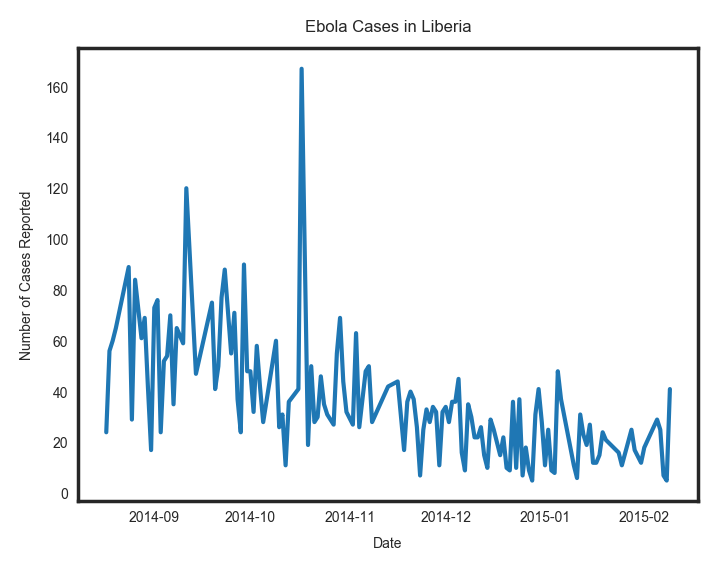

In [21]:
# matplotlib is a good tool for quick visualizations in python
plt.style.use('seaborn-white')
plt.rc('font', size=5)
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = plt.axes(title='Ebola Cases in Liberia', xlabel='Date', ylabel='Number of Cases Reported')

x = df['Date']
y = df['Value']
ax.plot(x, y)

The graph above shows a couple places where the number of cases significantly increased, but how much of an increase should warrant investigation? What if you have many metrics to track and don't have a human to look at the charts everyday? Statistics can help...


First we calculate a moving average and standard deviation for the data. In this example, we use a seven day window for the rolling statistics.

In [23]:
# Create a new column with the rolling mean
df['rolling_mean'] = df['Value'].rolling(7).mean()

In [24]:
# Create a new column with the rolling standard deviation
df['rolling_std'] = df['Value'].rolling(7).std()

Because the rolling statistics are calculated from the previous 7 days, the first six days of data will not have these data points.

In [25]:
df.head(10)

,Value,Date,rolling_mean,rolling_std
430,24,2014-08-17,NaN,NaN
461,56,2014-08-18,NaN,NaN
490,60,2014-08-19,NaN,NaN
537,65,2014-08-20,NaN,NaN
648,89,2014-08-24,NaN,NaN
734,29,2014-08-25,NaN,NaN
824,84,2014-08-26,58.142857,24.802074
948,61,2014-08-28,63.428571,19.738770
1044,69,2014-08-29,65.285714,19.533853
1106,42,2014-08-30,62.714286,21.437617


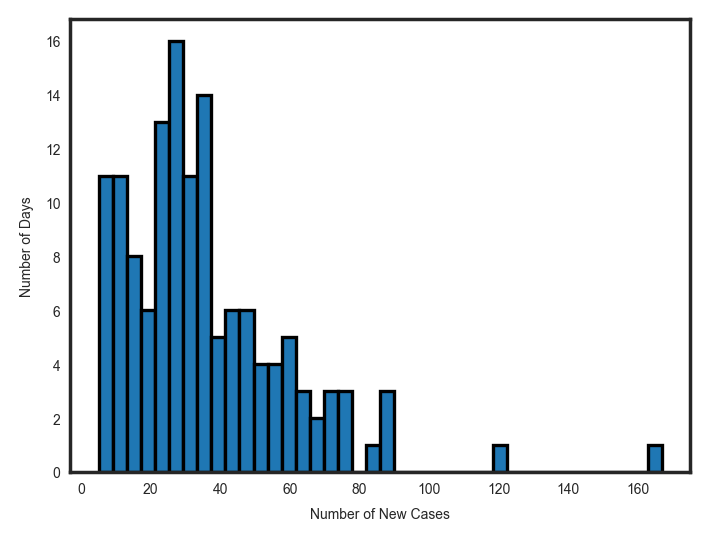

In [26]:
# A histogram of the values shows us the distribution of the data
plt.figure(figsize=(4, 3), dpi=200)
plt.xlabel('Number of New Cases')
plt.ylabel('Number of Days')
plt.hist(df['Value'], bins=40, edgecolor='black', linewidth=1.2)
plt.show()

The empirical rule tells us that, for normally distributed data, 95% of data points will lie within 2 standard deviations of the mean. You can choose the number of standard deviations to use depending on normal data trends for your situation and how drastic of an anomaly should warrant action or awareness.

<img src="img/empirical-rule.png" width="600">

[Image Source](https://courses.lumenlearning.com/atd-austincc-mathlibarts/chapter/the-empirical-rule/)

If the data is not normally distributed, Chebyshev's Inequality applies as long as there is a known, finite mean and variance. This states at least 1 - 1/_k_^2 of the values are within _k_ standard deviations of the mean.

<img src="img/chebyshev.png" width="400">

[Image Source](https://en.wikipedia.org/wiki/Chebyshev%27s_inequality)

In [28]:
# Add columns for the expected minimum and maximum values based on the rolling mean and standard deviation
df['exp_min'] = df['rolling_mean'] - 2*df['rolling_std']
df['exp_max'] = df['rolling_mean'] + 2*df['rolling_std']
df.head(10)

,Value,Date,rolling_mean,rolling_std,exp_min,exp_max
430,24,2014-08-17,NaN,NaN,NaN,NaN
461,56,2014-08-18,NaN,NaN,NaN,NaN
490,60,2014-08-19,NaN,NaN,NaN,NaN
537,65,2014-08-20,NaN,NaN,NaN,NaN
648,89,2014-08-24,NaN,NaN,NaN,NaN
734,29,2014-08-25,NaN,NaN,NaN,NaN
824,84,2014-08-26,58.142857,24.802074,8.538710,107.747004
948,61,2014-08-28,63.428571,19.738770,23.951031,102.906112
1044,69,2014-08-29,65.285714,19.533853,26.218007,104.353421
1106,42,2014-08-30,62.714286,21.437617,19.839051,105.589520


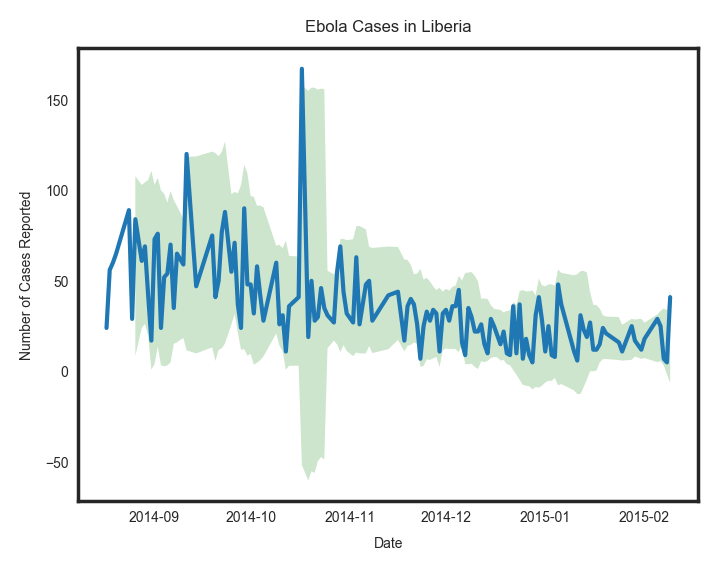

In [29]:
plt.style.use('seaborn-white')
plt.rc('font', size=5)
fig = plt.figure(figsize=(4, 3), dpi=200)
ax = plt.axes(title='Ebola Cases in Liberia', xlabel='Date', ylabel='Number of Cases Reported')

x = df['Date']
y = df['Value']
# Visualize again, this time with the expected value region
plt.fill_between(x, df['exp_min'], df['exp_max'], facecolor="green", alpha=0.2)
ax.plot(x, y)

In [30]:
# Create a function that can be applied to each row to determine if the value is an outlier 
# (greater than the maximum expected value or less than the minimum expected value)
def is_outlier(row):
    if row.Value > row.exp_max or row.Value < row.exp_min:
        return True
    else:
        return False

In [31]:
# Create a new column with the result of the outlier check
df['outlier'] = df.apply(lambda row: is_outlier(row), axis=1)
df.tail()

,Value,Date,rolling_mean,rolling_std,exp_min,exp_max,outlier
16306,29,2015-02-05,18.285714,6.575568,5.134578,31.436850,False
16338,25,2015-02-06,19.571429,6.924766,5.721897,33.420960,False
16370,7,2015-02-07,19.000000,7.852813,3.294375,34.705625,False
16672,5,2015-02-08,16.142857,8.877473,-1.612089,33.897803,False
16704,41,2015-02-09,19.571429,12.959644,-6.347860,45.490717,False


In [32]:
# Look for the rows with outlier=True to see the days that fit the parameters we defined for an outlier
df[(df['outlier'] == True)]

,Value,Date,rolling_mean,rolling_std,exp_min,exp_max,outlier
2056,120,2014-09-11,65.000000,26.695817,11.608365,118.391635,True
5038,167,2014-10-17,53.142857,52.368657,-51.594456,157.880170,True


Try on your own!


Conduct similar analysis for a different country or locality. How many anomalies did you find? What differences do you see if you change the size of the window from 7 days? What about changing the number of standard deviations used to determine the expected data range?